# Hotel prediction

## Content

* [1. Loading the data and python packages](#0)
* [2. Data Visualization](#1)
* [3. Data Preparation and cleaning](#2)
* [4. Evaluate Algorithms and Model](#3)
    * [4.1 Train test split](#3.1)
    * [4.2. Tree models](#3.2)
    * [4.3. Logistic Regression](#3.3)
    * [4.4. SVC](#3.4)
* [5. Model Evaluation](#4)        
* [6. Inplication](#5)  


# 1. Loading the data and python packages <a id='0'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import RFE 
from sklearn.svm import SVC
import random
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [2]:
df = pd.read_csv('/Users/kevinleungch421/Desktop/hotel_bookings.csv')
#df.head()

# 2. Data Visualization <a id='1'></a>

# 3. Data Preparation <a id='2'></a>

## 3.1 Data Cleaning
Problems:
1. Random Sampling: We sampled 40,000 data points randomly from the dataset (df) to improve processing time.
2. 'Season' Creation: We created a 'season' feature from the 'arrival_date_month' column to simplify the representation of seasons.
3. Feature Deletion: We removed irrelevant and complex features to reduce the dataset's complexity.
4. Null Value Handling: There were null values in the 'children' column, which were addressed during preprocessing.
5. Data Type Correction: We corrected the data type of the 'children' column.
6. Categorical Value Consolidation: 'Undefined' and 'SC' values in the 'meal' column were consolidated as they referred to the same category.
7. Outlier Detection: Outliers were identified in some numeric columns and further analyzed.

Report of data cleaning:

1. after the random sample, the number of rows is: 40000

2. change the 'arrival_date_month' to 'seaon', it have unique value: ['Winter' 'Summer' 'Spring' 'Autumn']

3. after delete meaningless columns, the number of columns is: 24

4. 'children' column contain any null values? False

5. 'children' is changed to float64

6. 'meal' have unique value: ['BB' 'SC' 'HB' 'FB']

7.


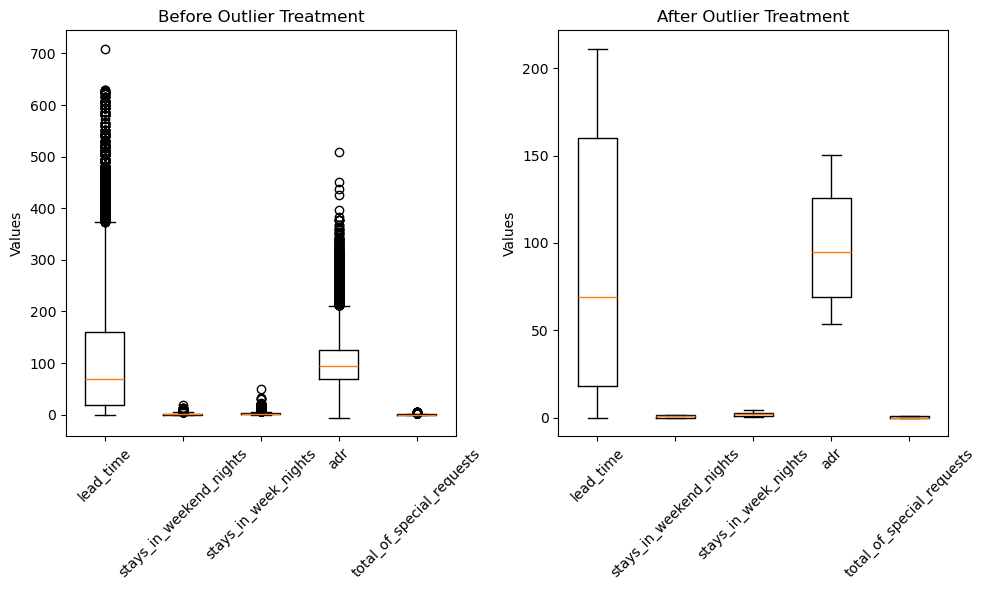

In [3]:
print("Report of data cleaning:")
print()


# 1. randomly sample 40000 data
random_seed = 42
df = df.sample(n=40000, random_state=random_seed, replace=False)
print('1. after the random sample, the number of rows is: {}'.format(len(df)))
print()


# 2. New feature 'season'
month_to_season = {'January': 'Winter','February': 'Winter','March': 'Spring','April': 'Spring','May': 'Spring','June': 'Summer','July': 'Summer','August': 'Summer','September': 'Autumn','October': 'Autumn','November': 'Autumn','December': 'Winter'}
df['season'] = df['arrival_date_month'].replace(month_to_season)
print("2. change the 'arrival_date_month' to 'seaon', it have unique value: {}".format(df['season'].unique()))
print()


#3) delete meaningness and complex feature
useless_col = ['assigned_room_type',           #assigned room type have no relationship canceled room
               'country',                      #too much category, not effecient to do one hot encoding for all
               'arrival_date_week_number',     #too much category, not effecient to do one hot encoding for all
               'arrival_date_day_of_month',    #too much category, not effecient to do one hot encoding for all
               'agent',                        #it is ID, too much category, not effecient to do one hot encoding for all
               'company',                      #it is ID, too much category, not effecient to do one hot encoding for all
               'reservation_status_date',      #it is date
               'reservation_status',           #same as is_canceled
               'arrival_date_month']
df = df.drop(columns=[col for col in useless_col if col in df.columns])
print('3. after delete meaningless columns, the number of columns is: {}'.format(len(df.columns)))
print()


# 4) clean null value in 'children'
df['children'] = df['children'].fillna(0) # NULL in children could mean 0 children
print("4. 'children' column contain any null values?", df['children'].isnull().any())
print()


# 5) correct the data type in 'children'
df['children'].astype('int64')
print("5. 'children' is changed to {}".format(df['children'].dtype))
print()


# 6) correct the irrcorrect data format by merging 'Undefined' values into 'SC' category
df['meal'].replace('Undefined', 'SC', inplace=True) 
print("6. 'meal' have unique value: {}".format(df['meal'].unique()))
print()


# 7) Handle outliner in 'lead_time','stays_in_weekend_nights','stays_in_week_nights','adr','total_of_special_requests'

print("7.")

# Before Handle outliner
numeric_features_outliner = ['lead_time','stays_in_weekend_nights','stays_in_week_nights','adr','total_of_special_requests']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes[0].boxplot(df[numeric_features_outliner])
axes[0].set_title('Before Outlier Treatment')
axes[0].set_xticklabels(numeric_features_outliner, rotation=45)
axes[0].set_ylabel('Values')

# Handle outliner
for feature in numeric_features_outliner:
    mean = df[feature].mean()
    std = df[feature].std()
    upper_limit = mean + std
    lower_limit = mean - std

    # Replace outliers with mean +- std
    df[feature] = np.where(df[feature] > upper_limit, upper_limit, df[feature])
    df[feature] = np.where(df[feature] < lower_limit, lower_limit, df[feature])

# After Handle outliner
axes[1].boxplot(df[numeric_features_outliner])
axes[1].set_title('After Outlier Treatment')
axes[1].set_xticklabels(numeric_features_outliner, rotation=45)
axes[1].set_ylabel('Values')
plt.tight_layout()
plt.show()

## 3.2 Preparing the data for classification

- We use: One Hot encoding
- Reason: by converting categorical variables into numeric values through One Hot encoding, we can represent categorical information in a way that algorithms can process.
- we now have 40000 rows with 48 columns

In [4]:
columns_to_encode = ['hotel', 'arrival_date_year', 'is_repeated_guest', 'meal', 'market_segment', 'distribution_channel','reserved_room_type', 'deposit_type', 'customer_type', 'season']

df_encoded = pd.get_dummies(df, columns=columns_to_encode, prefix="dummy", drop_first=True)

columns_to_convert = ['dummy_Resort Hotel', 'dummy_2016', 'dummy_2017', 'dummy_1', 'dummy_FB','dummy_HB', 'dummy_SC', 'dummy_Complementary', 'dummy_Corporate','dummy_Direct', 'dummy_Groups', 'dummy_Offline TA/TO','dummy_Online TA', 'dummy_GDS', 'dummy_TA/TO','dummy_B', 'dummy_C', 'dummy_D', 'dummy_E','dummy_F', 'dummy_G', 'dummy_H', 'dummy_L', 'dummy_P','dummy_Non Refund', 'dummy_Refundable', 'dummy_Group','dummy_Transient', 'dummy_Transient-Party', 'dummy_Spring','dummy_Summer', 'dummy_Winter']

for column in columns_to_convert:
    df_encoded[column] = df_encoded[column].astype(int)

df_encoded.head()

is_canceled  lead_time  stays_in_weekend_nights  stays_in_week_nights  \
30946             0      203.0                  1.91624              4.382241   
40207             1       82.0                  0.00000              3.000000   
103708            0       25.0                  0.00000              3.000000   
85144             0        1.0                  0.00000              1.000000   
109991            0       70.0                  1.91624              2.000000   

        adults  children  babies  previous_cancellations  \
30946        2       0.0       0                       0   
40207        2       0.0       0                       0   
103708       3       0.0       0                       0   
85144        1       0.0       0                       0   
109991       2       0.0       0                       0   

        previous_bookings_not_canceled  booking_changes  ...  dummy_L  \
30946                                0                4  ...        0   
40207                                0                0  ...        0   
103708                               0                2  ...        0   
85144                                0                0  ...        0   
109991                               0                0  ...        0   

        dummy_P  dummy_Non Refund  dummy_Refundable  dummy_Group  \
30946         0                 0                 0            0   
40207         0                 0                 0            0   
103708        0                 0                 0            0   
85144         0                 0                 0            0   
109991        0                 0                 0            0   

        dummy_Transient  dummy_Transient-Party  dummy_Spring  dummy_Summer  \
30946                 1                      0             0             0   
40207                 1                      0             0             1   
103708                0                      1             0             0   
85144                 0                      1             1             0   
109991                1                      0             1             0   

        dummy_Winter  
30946              1  
40207              0  
103708             1  
85144              0  
109991             0  

[5 rows x 48 columns]

## 3.3 Data Inspect
insight after visualized:
1. histogram (feature), we see that some data is not normalized, and skewed
2. histogram (is_canceled), we see that we have imbalance cancel and not cancel, it indicate that accuracy alone may not be the best metrics for evaluating model performance
3. correlation matrix

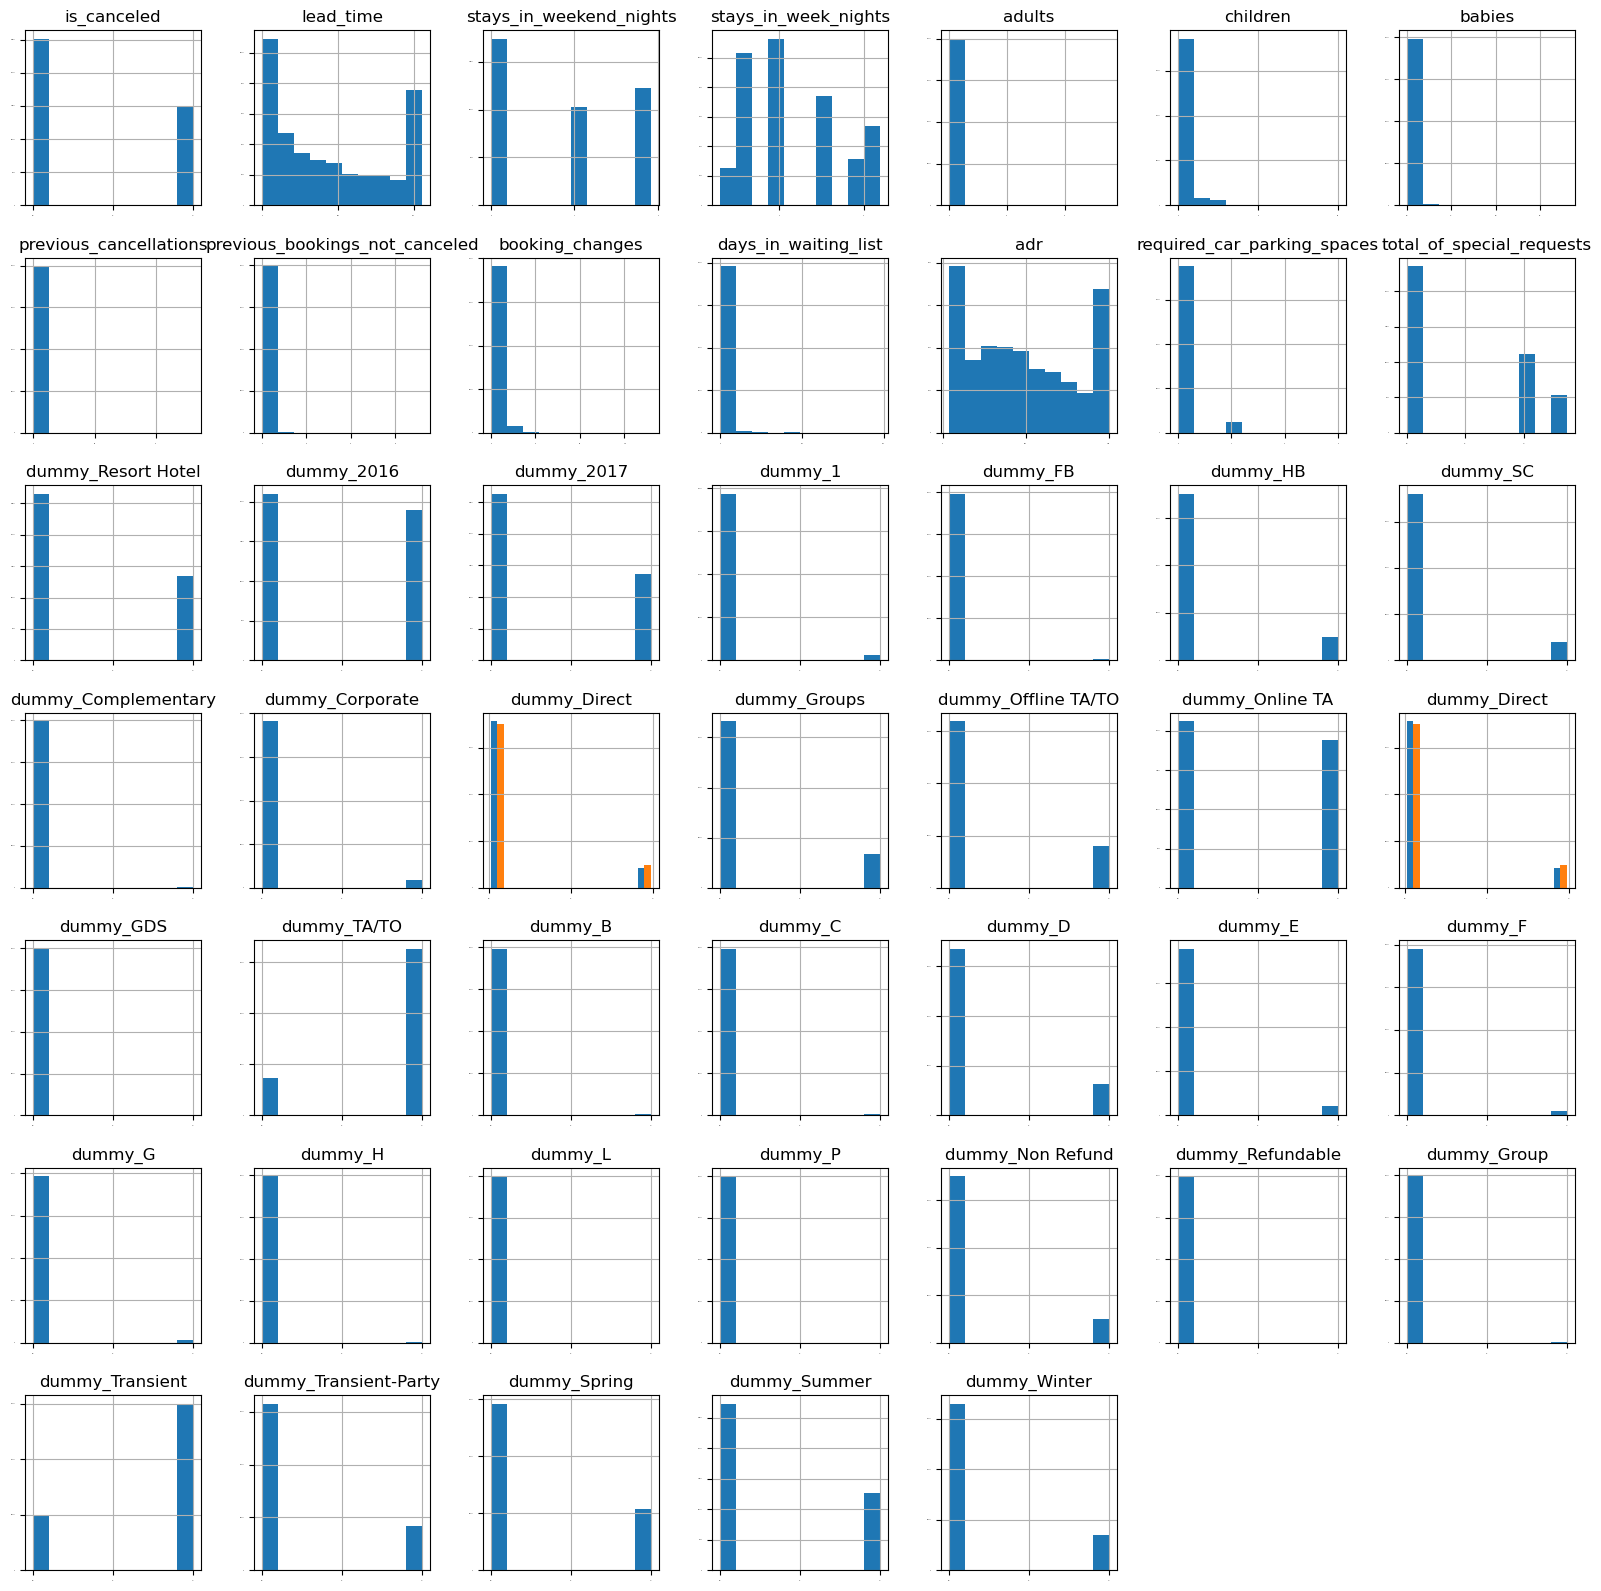

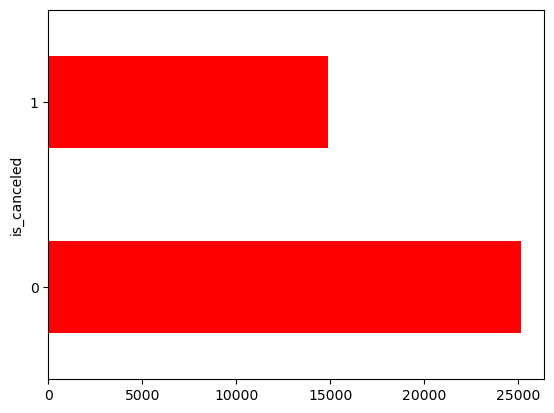

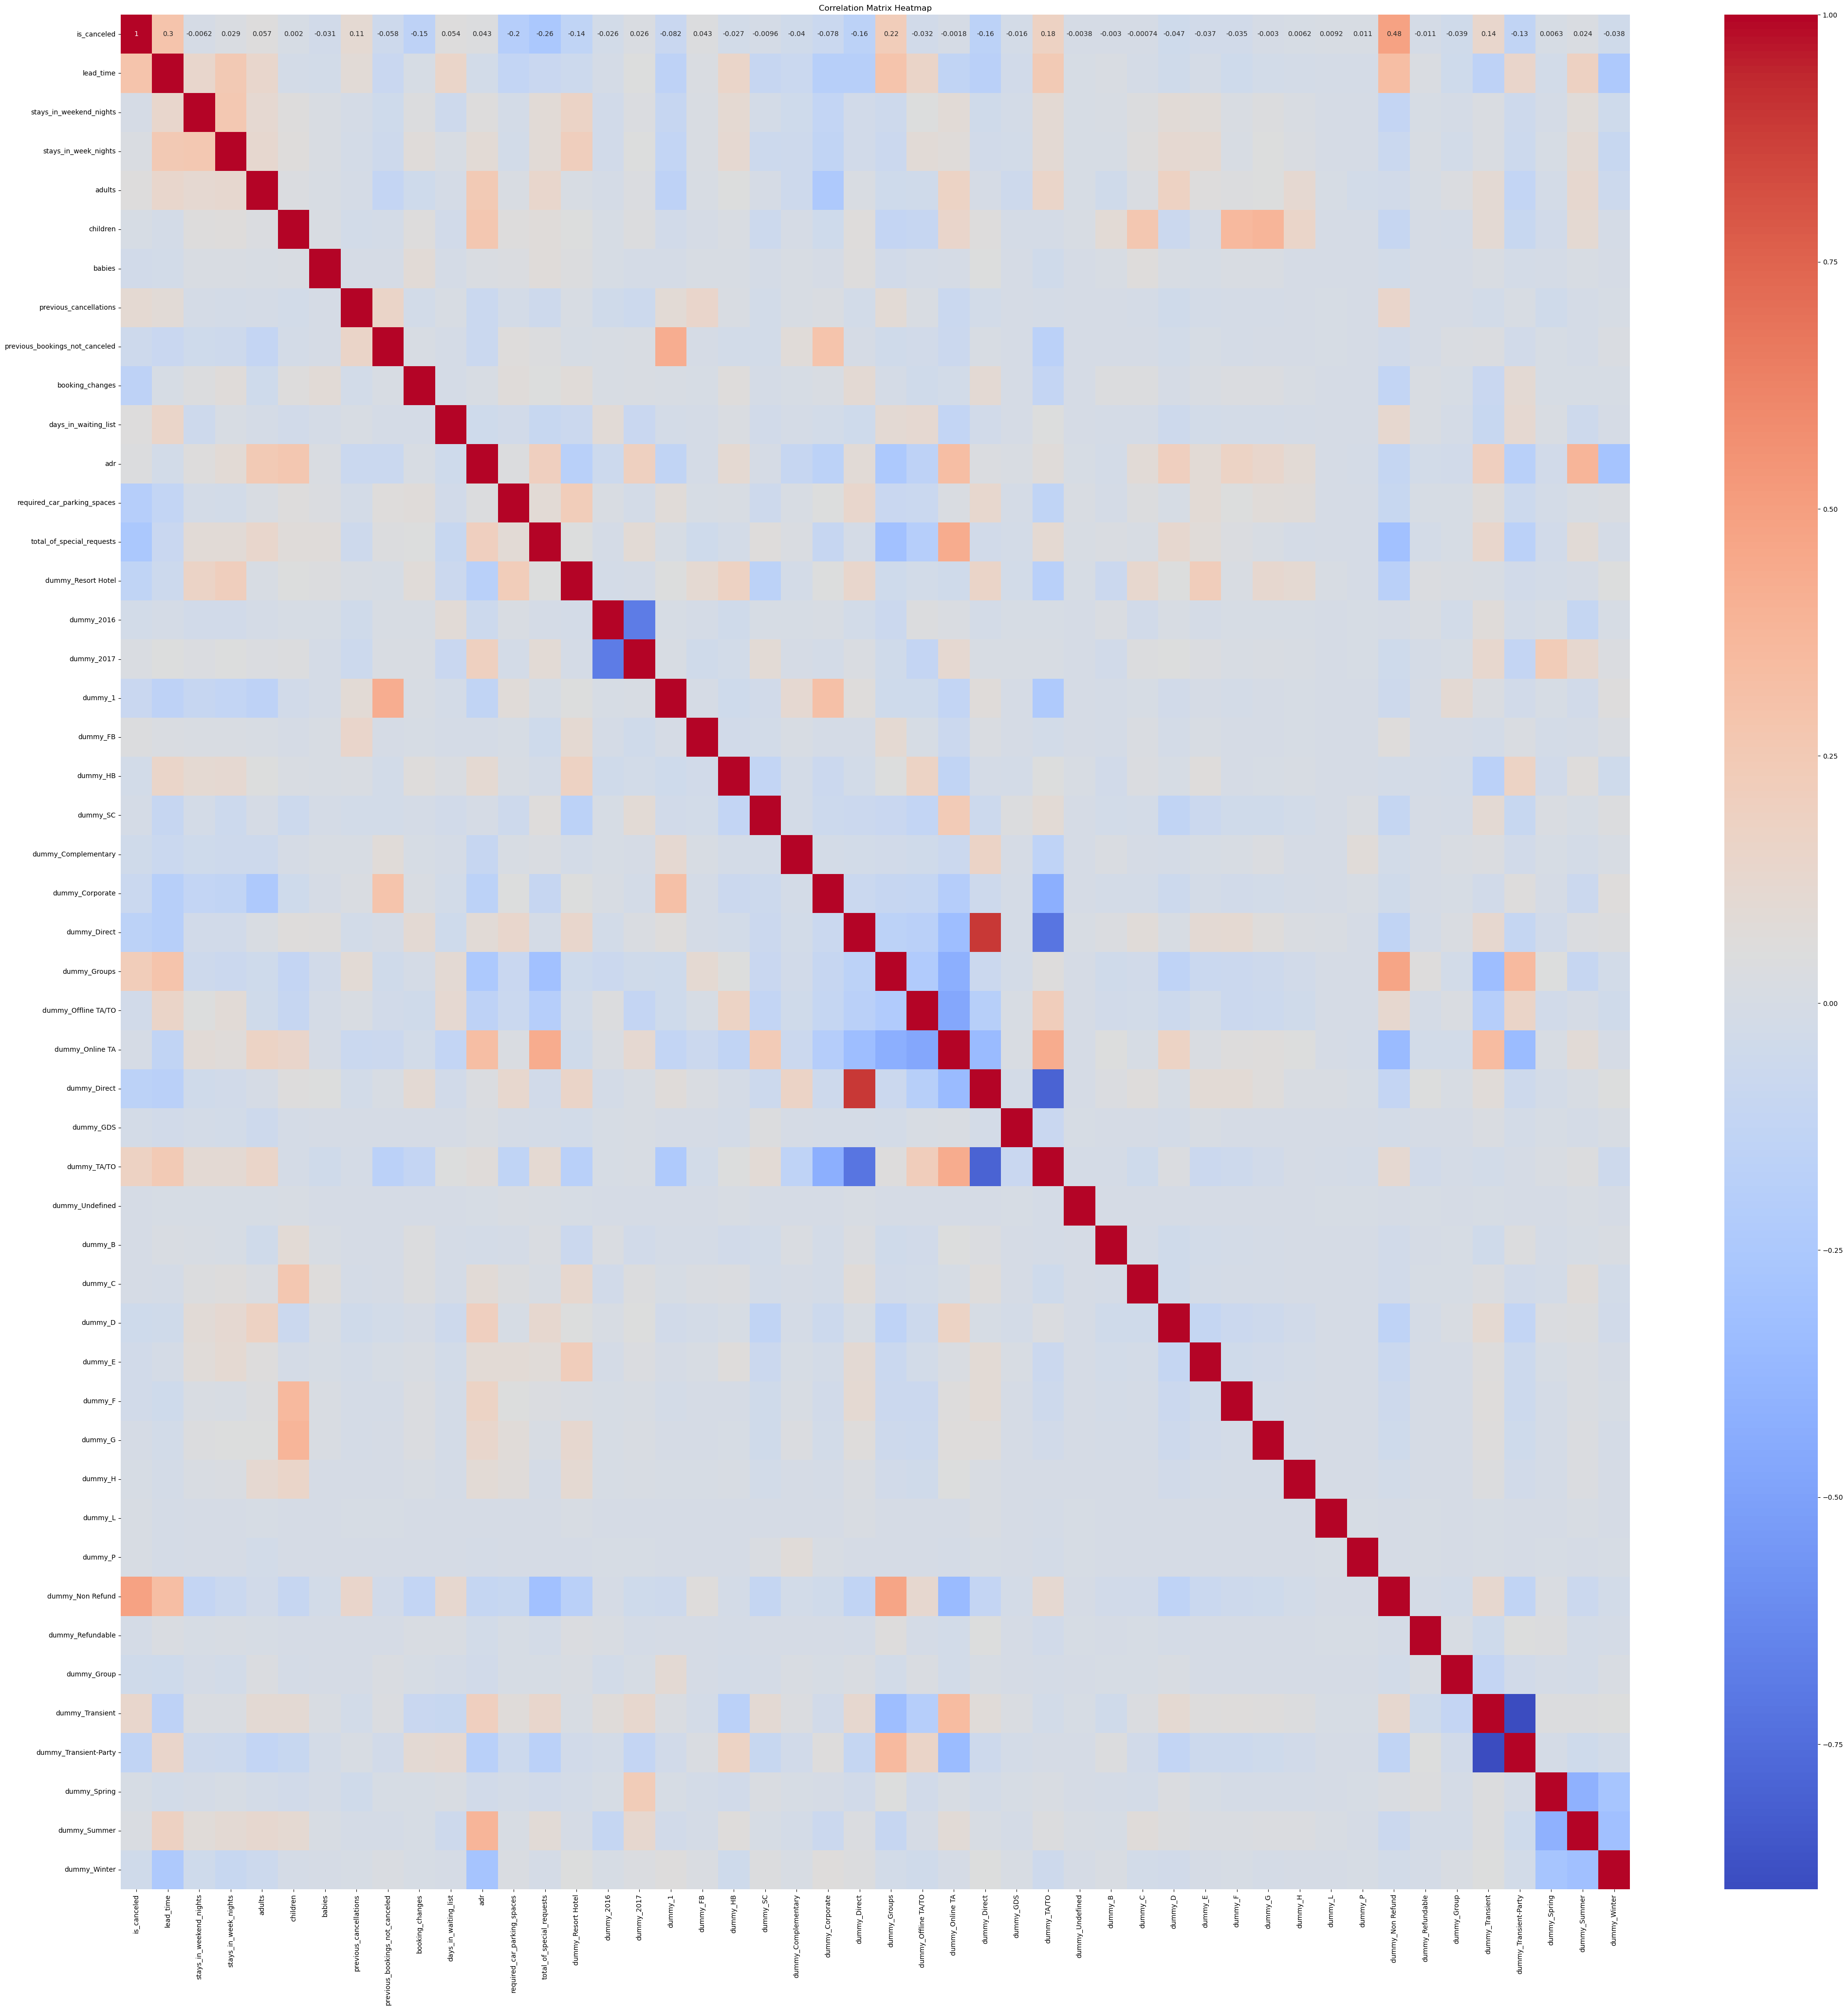

In [5]:
# 1) Histogram for feature
df_encoded.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(20, 20))
plt.show()


# 2) Histogram for target
fig = plt.figsize=()
plot = df.groupby(['is_canceled']).size().plot(kind='barh', color='red')
plt.show()


# 3) correlation matrix
plt.figure(figsize=(50,50))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# 4. Evaluate Algorithms and Model <a id='3'></a>

## 4.1 Train test split <a id='3.1'></a>
1. Dataset split: We divided the data into 80% training and 20% test sets.
2. MinMaxScaler: after observed significant differences between variables in Box plot analysis above, we opted to scale the data. Scaling ensures feature values are between 0 and 1, addressing variations in the data.


In [6]:
# 1) 80-20 split
y = df_encoded['is_canceled']
X = df_encoded.drop('is_canceled', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


# 2) scale X_train and y_train
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled  = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_train.columns)


# 3) result
print()
print("shape of the Train Test Split:")
print()
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


shape of the Train Test Split:

X_train_scaled shape: (32000, 47)
X_test_scaled shape: (8000, 47)
y_train shape: (32000,)
y_test shape: (8000,)


## 4.2 Tree Models <a id='3.2'></a>

### 4.2.1 Define Tree models and visualization
1. Model selection: We selected three tree-related models for analysis: Decision Tree, Random Forest, and Gradient Boosting models.
2. Perform visualization for ptt presentation: We created visualizations to present our analysis of the models.

In [7]:
# 3.2.1.a) Decision Tree model
dt = DecisionTreeClassifier(criterion='entropy', random_state=1)
dt.fit(X_train_scaled, y_train)

# 3.2.1.b) Random Forest model
rf = RandomForestClassifier(criterion='entropy', random_state=1)
rf.fit(X_train_scaled, y_train)

# 3.2.1.c) Gradient Boosting model
gb = GradientBoostingClassifier(random_state=1)
gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=1)

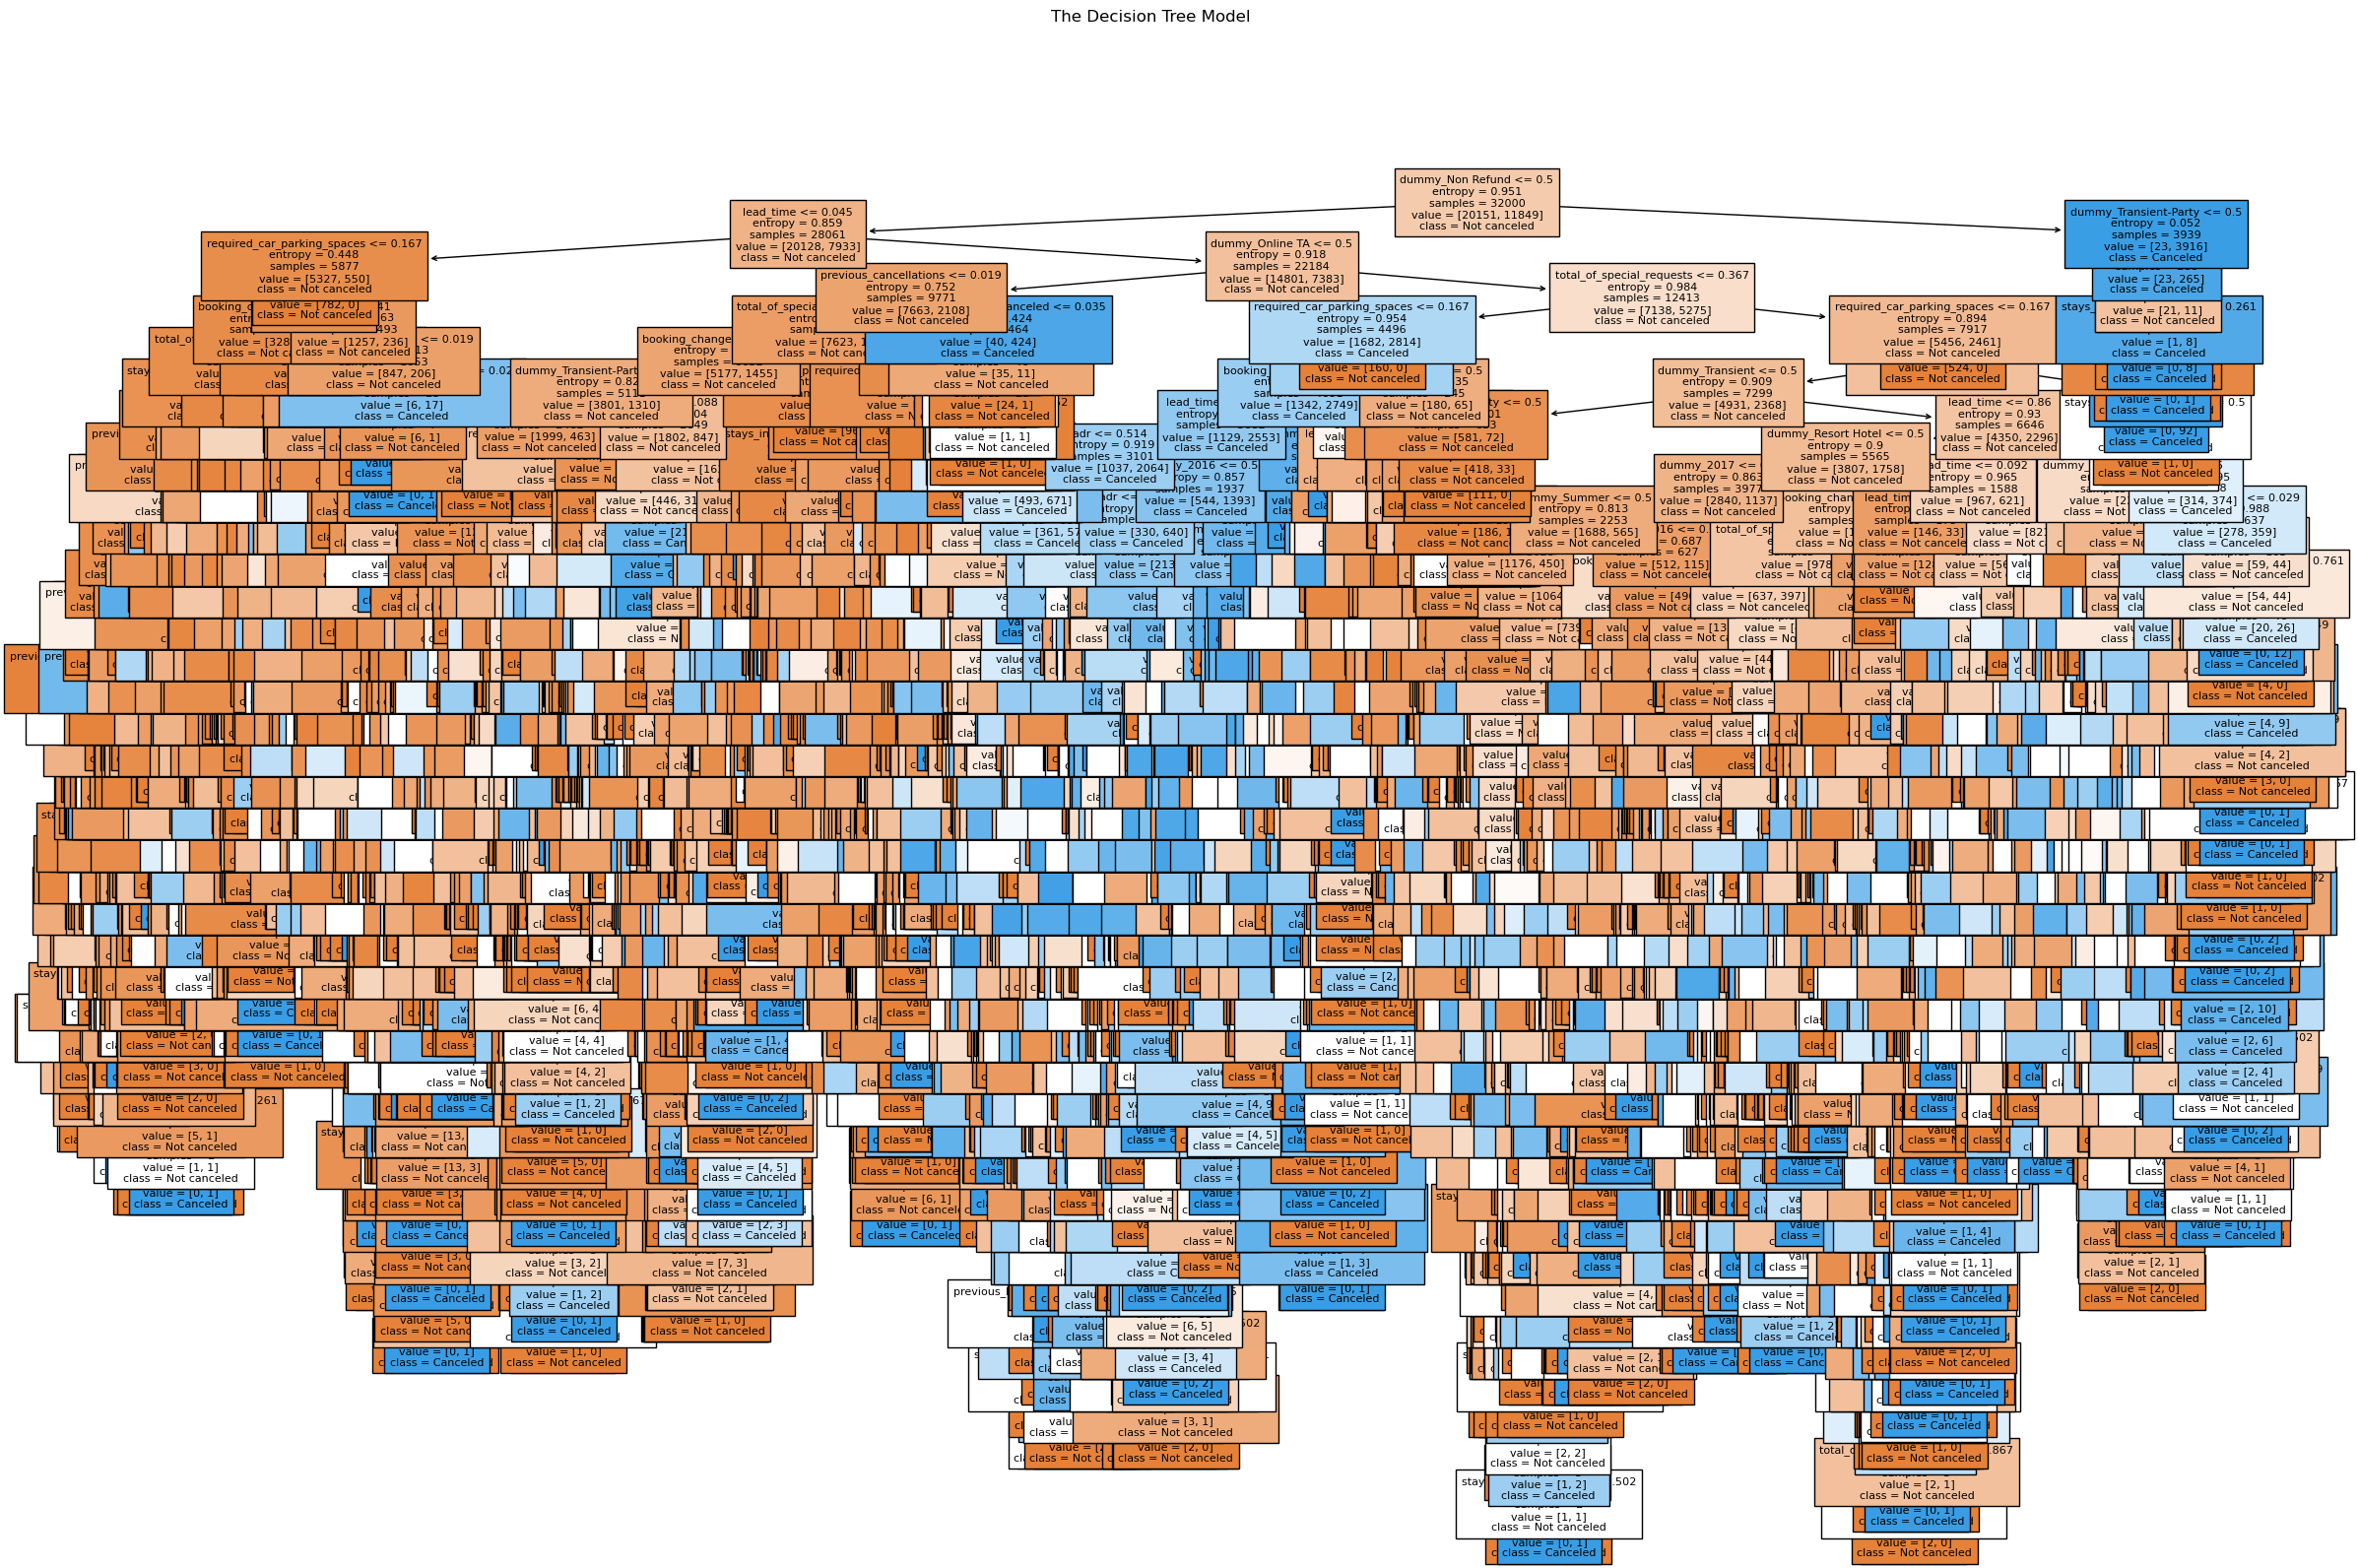

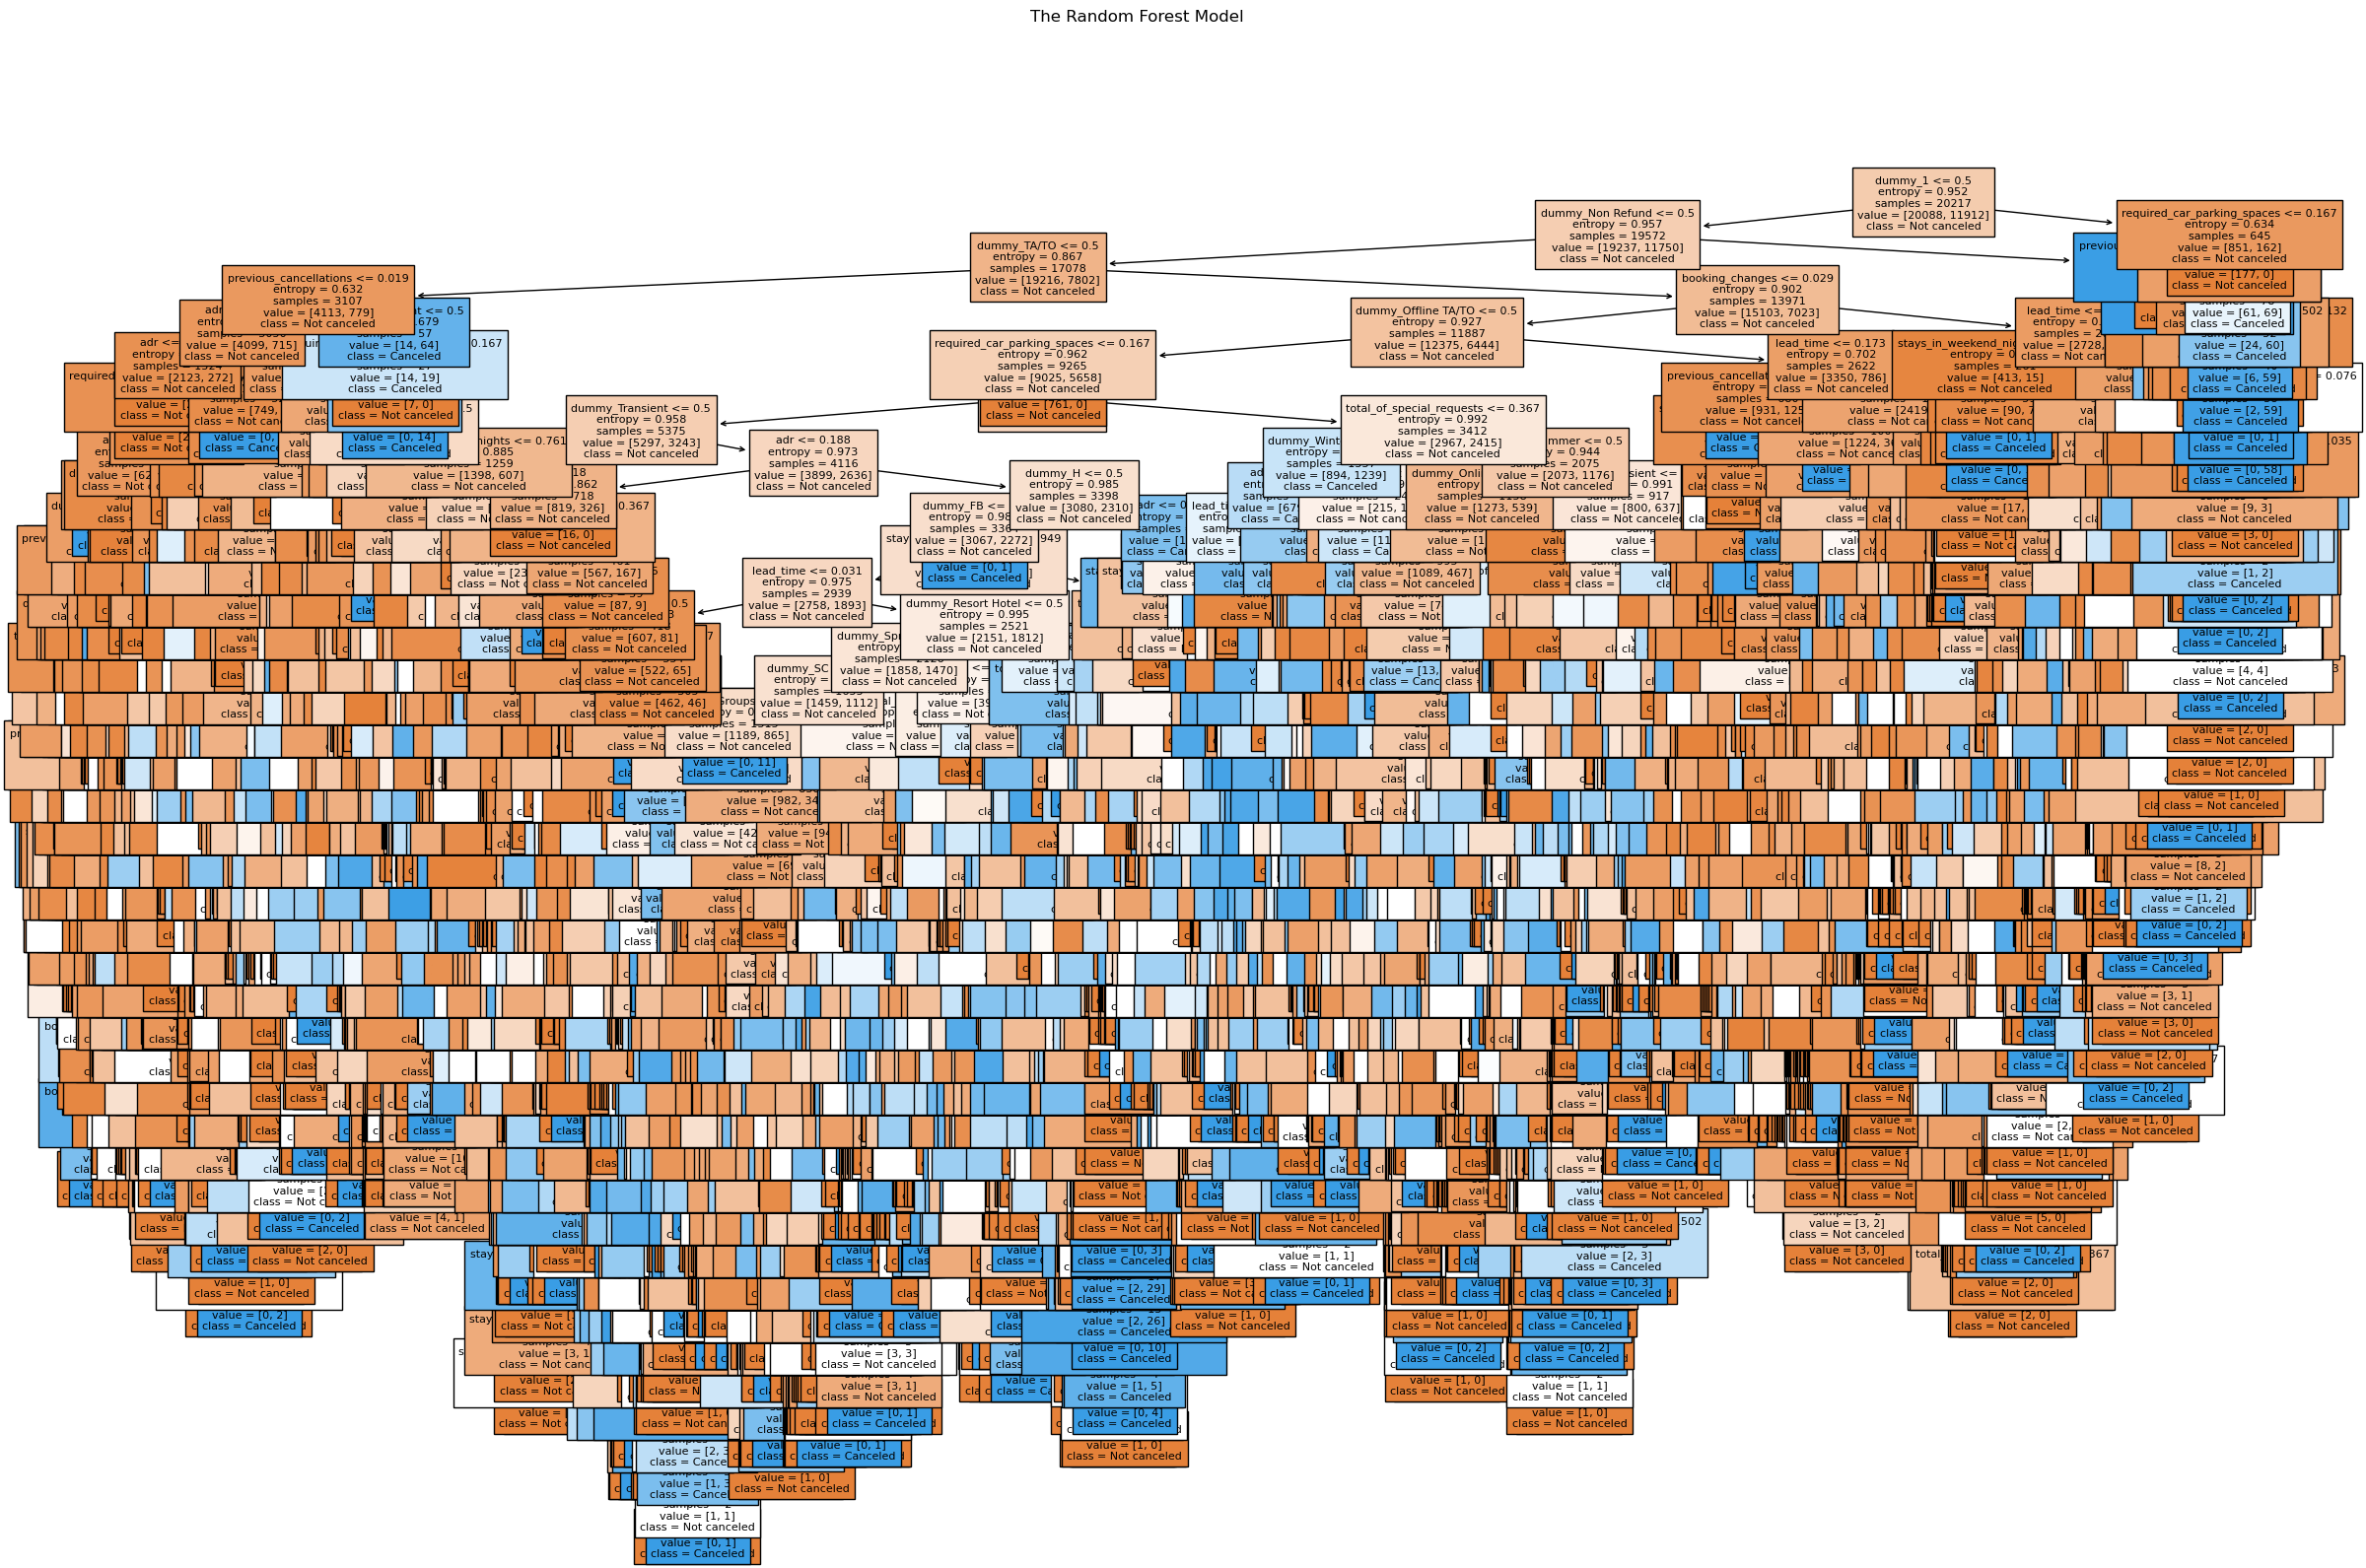

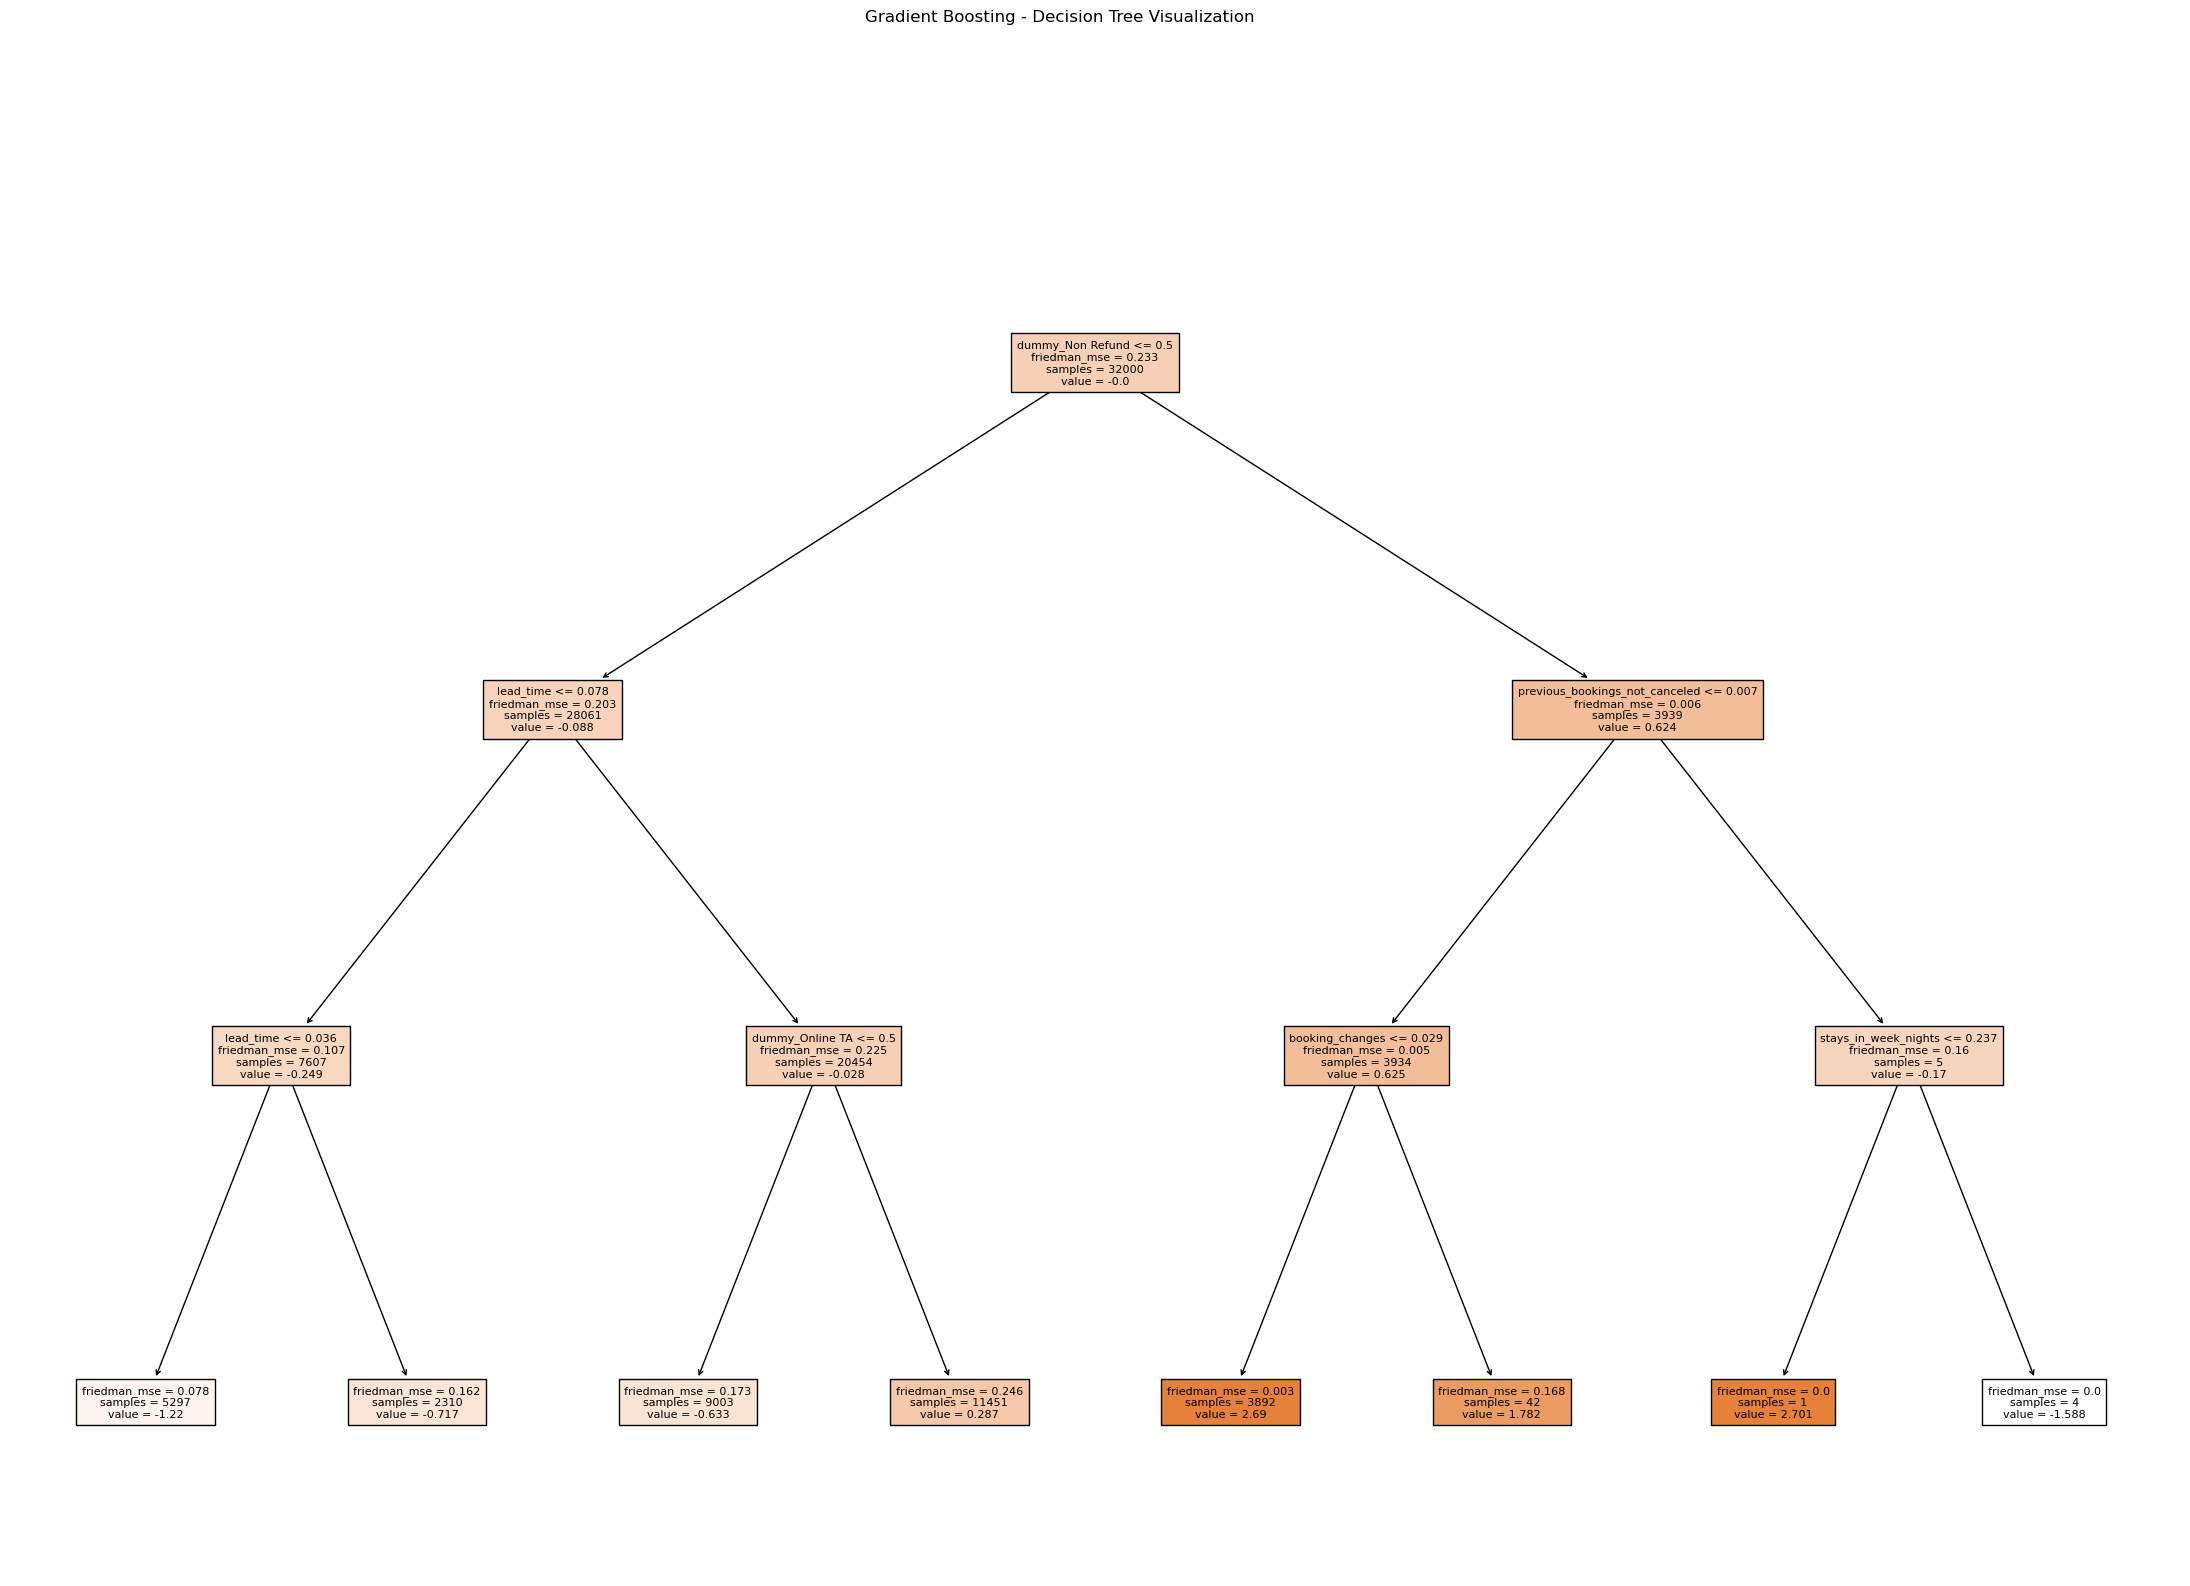

In [77]:
# visualize Decision Tree model
fig = plt.figure(figsize=(28, 18))
plot_tree(decision_tree=dt, feature_names=X_train.columns.to_list(),class_names=['Not canceled', 'Canceled'],filled=True,fontsize=8)
fig.suptitle('The Decision Tree Model')
plt.show()


# visualize Random Forest model (Select a tree from the forest for visualization)
tree = rf.estimators_[0]
fig = plt.figure(figsize=(28, 18))
plot_tree(decision_tree=tree, feature_names=X_train.columns.to_list(),class_names=['Not canceled', 'Canceled'],filled=True,fontsize=8)
fig.suptitle('The Random Forest Model')
plt.show()


# visualize Gradient Boosting model (Select a tree from the forest for visualization)
tree = gb.estimators_[0, 0]
fig = plt.figure(figsize=(28, 18))
plot_tree(decision_tree=tree,feature_names=X_train_scaled.columns.to_list(),class_names=['Not canceled', 'Canceled'],filled=True,fontsize=8)
fig.suptitle('Gradient Boosting - Decision Tree Visualization')
plt.show()

### 4.2.2 Set Evaluation Metrics (Tree Models)
- Precision score measures the accuracy of positive predictions, indicating the proportion of true positives among all positive predictions.
- It focuses on avoiding false positives.
- Higher precision means fewer false positives.

In [8]:
num_folds = 10
seed = 7
#scoring = 'accuracy'
scoring = 'precision'
#scoring = 'recall'
#scoring = make_scorer(f1_score)

### 4.2.3 Find the best Tree Models - by Compare Precision using K-fold cross validation 
- we sets up a for loop to iterate over three tree models (Decision Tree, Random Forest, Gradient Boosting) using 10-fold cross-validation.
- It calculates the average precision score for each model.
- the result shows that Gradient Boosting is the best tree model with Average precision score of GB: 0.995230

In [9]:
models = []
models.append(('DT', dt))
models.append(('RF', rf))
models.append(('GB', gb))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "Average precision score of %s: %f" % (name, cv_results.mean())
    print(msg)

Average precision score of DT: 0.721028
Average precision score of RF: 0.830840
Average precision score of GB: 0.848344


### 4.2.4 Gradient Boosting is the best tree model
- Average precision score of DT: 0.721028
- Average precision score of RF: 0.830840
- Average precision score of GB: 0.848344

### 4.2.5 Model Tuning for Gradient Boosting - by using Grid Search
- aim to find the best hyperparameter combination for gb
- the evaluation metric for finding it, is using Precision
- the best hyperperemeter for Gradient Boosting is {'learning_rate': 0.1, 'n_estimators': 50}, it have 0.863660 precision score

In [11]:
param_grid = {'n_estimators': [200, 500], 'max_depth': [3, 5, 7, None]}

gb = GradientBoostingClassifier(random_state=1)

grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

print("Best score: %f" % grid_search.best_score_)

print("Best parameters: ", grid_search.best_params_)

#Best score: 0.834500
#Best parameters:  {'max_depth': 7, 'n_estimators': 200}

Best score: 0.834500
Best parameters:  {'max_depth': 7, 'n_estimators': 200}


### 4.2.6 Redefine Gradient Boosting - after find out the best hypermeter

In [77]:
# 1) fit the model with grid search result of hyperperemeter
gb = GradientBoostingClassifier(n_estimators = 200, max_depth = 7, random_state=1)
gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(max_depth=7, n_estimators=200, random_state=1)

### 4.2.7 Take a look for the performance of best tree models - GradientBoostingClassifier(max_depth=7, n_estimators=200, random_state=1)

In [78]:
# 2) training accuracy and testing accuracy

train_predictions = gb.predict(X_train_scaled)
test_predictions = gb.predict(X_test_scaled)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Gradient Boosting Train accuracy:", train_accuracy)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Gradient Boosting Test accuracy:", test_accuracy)

Gradient Boosting Train accuracy: 0.885375
Gradient Boosting Test accuracy: 0.84275


In [79]:
# 3) classification report

classification_rep = classification_report(y_test, test_predictions)
print("Gradient Boosting Classification Report:")
print(classification_rep)

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4989
           1       0.85      0.71      0.77      3011

    accuracy                           0.84      8000
   macro avg       0.85      0.82      0.83      8000
weighted avg       0.84      0.84      0.84      8000



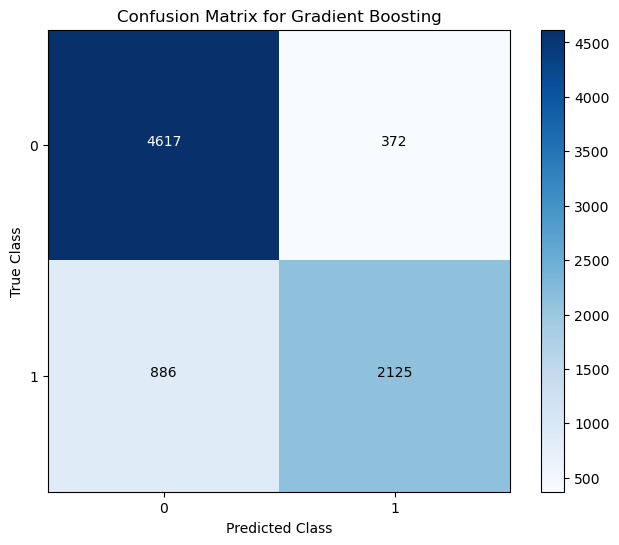

In [80]:
# 4) confusion matrix

test_cm = confusion_matrix(y_test, test_predictions)
class_labels = np.unique(y_train)
plt.figure(figsize=(8, 6))
plt.imshow(test_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Gradient Boosting")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
thresh = test_cm.max() / 2.
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        plt.text(j, i, format(test_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if test_cm[i, j] > thresh else "black")

plt.show()

## 4.3 Logistic Regression <a id='3.3'></a>

### 4.3.1 Define Logistic Regression models and visualization
- Model selection: We selected three tree-related models for analysis: Decision Tree, Random Forest, and Gradient Boosting models.
- Perform visualization for ptt presentation: We created visualizations to present our analysis of the models.

In [21]:
# a) Logistic regression model

logit = LogisticRegression()

logit.fit(X_train_scaled, y_train)

# b) RFE

logit_rfe = RFE(estimator=LogisticRegression(), n_features_to_select= 20, verbose=1)

logit_rfe.fit(X_train_scaled, y_train)

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.


RFE(estimator=LogisticRegression(), n_features_to_select=20, verbose=1)

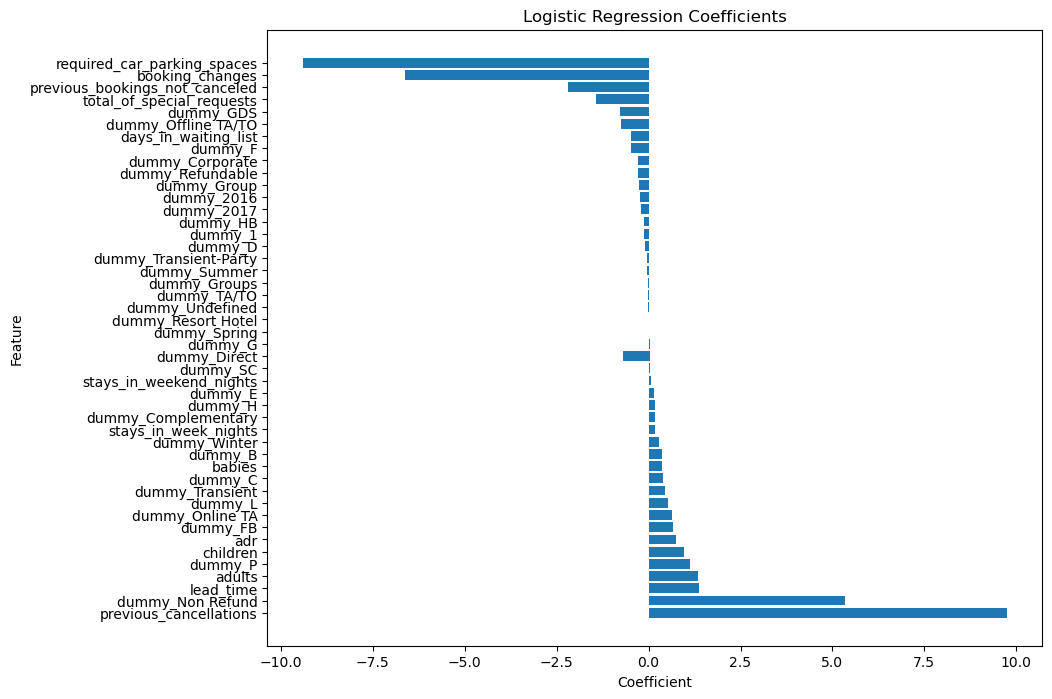

In [22]:
# visualization of Logit() coefficient

coefficients_logit = logit.coef_[0]
coefficients_df_logit = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients_logit})
coefficients_df_logit = coefficients_df_logit.sort_values(by='Coefficient', ascending=False)
plt.figure(figsize=(10, 8))
plt.barh(coefficients_df_logit['Feature'], coefficients_df_logit['Coefficient'])
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

# we didnt visualization for logit_rfe() coefficient, because it is the same besides of choosing the top 20 feature


### 4.3.2 Set Evaluation Metrics (Logistic Regression Models)
- Precision score measures the accuracy of positive predictions, indicating the proportion of true positives among all positive predictions.
- It focuses on avoiding false positives.
- Higher precision means fewer false positives.

In [23]:
num_folds = 10
seed = 7
#scoring = 'accuracy'
scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

### 4.3.3 Find the best Logistic Regression Models - by Compare Precision using K-fold cross validation 
- we sets up a for loop to iterate over three tree models (Logistic regression, RFE) using 10-fold cross-validation.
- It calculates the average precision score for each model.
- the result shows that Gradient Boosting is the best tree model with Average precision score of GB: 0.995230

In [24]:
models = []
models.append(('Logit', logit))
models.append(('logit_rfe', logit_rfe))

In [25]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "Average precision score of %s: %f" % (name, cv_results.mean())
    print(msg)

# Average precision score of Logit: 0.822939
# Average precision score of logit_rfe: 0.831619

Average precision score of Logit: 0.822939
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator wit

### 4.3.4 RFE is the best logistic regression model  
-   Average precision score of Logit: 0.822939
-   Average precision score of logit_rfe: 0.831619

### 4.3.5 Redefine the logit_rfe Model

In [70]:
logit_rfe = RFE(estimator=LogisticRegression(), n_features_to_select= 20, verbose=1)

logit_rfe.fit(X_train_scaled, y_train)

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.


RFE(estimator=LogisticRegression(), n_features_to_select=20, verbose=1)

### 4.3.6 Take a look for the performance of best logistic regression models - RFE(estimator=LogisticRegression(), n_features_to_select= 20, verbose=1)

In [71]:
# Train predictions and accuracy
train_predictions = logit_rfe.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_predictions)
print("RFE Logistic Regression Train accuracy:", train_accuracy)

# Test predictions and accuracy
test_predictions = logit_rfe.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)
print("RFE Logistic Regression Test accuracy:", test_accuracy)

RFE Logistic Regression Train accuracy: 0.798375
RFE Logistic Regression Test accuracy: 0.798875


In [72]:
# Classification report
classification_rep = classification_report(y_test, test_predictions)
print("RFE Logistic Regression Classification Report:")
print(classification_rep)

RFE Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      4989
           1       0.84      0.57      0.68      3011

    accuracy                           0.80      8000
   macro avg       0.81      0.75      0.77      8000
weighted avg       0.81      0.80      0.79      8000



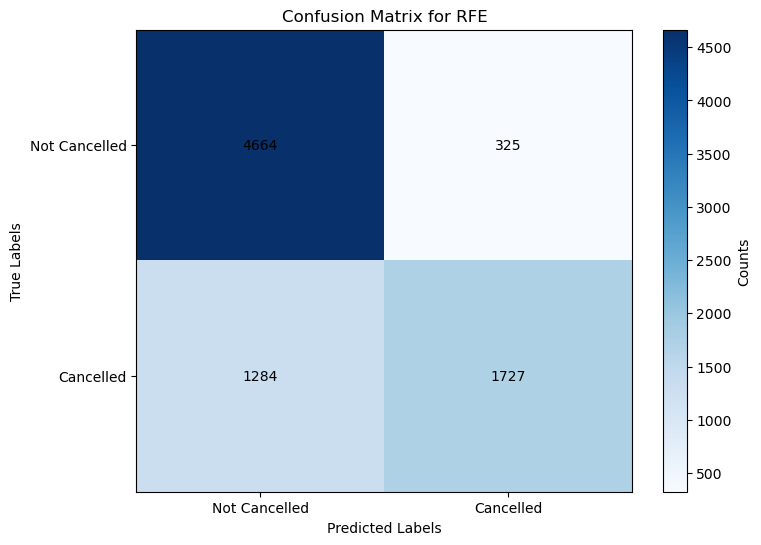

In [73]:
# confusion matrix

confusion_mat = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat, cmap='Blues', aspect='auto')
plt.colorbar(label='Counts')
class_names = ['Not Cancelled', 'Cancelled']
tick_marks = [0, 1]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, str(confusion_mat[i, j]), ha='center', va='center', color='black')

plt.title('Confusion Matrix for RFE')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.grid(False)
plt.show()

## 4.4 SVC <a id='3.4'></a>

### 4.4.1 Define SVC models and visualization

In [30]:
# 1) Create the linear SVC model
svc_linear = SVC(kernel='linear')
svc_linear.fit(X_train_scaled, y_train)

# 2) Create the polynomial SVC model
svc_poly = SVC(kernel='poly')
svc_poly.fit(X_train_scaled, y_train)

# 3) Create the SVM model
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)

SVC()

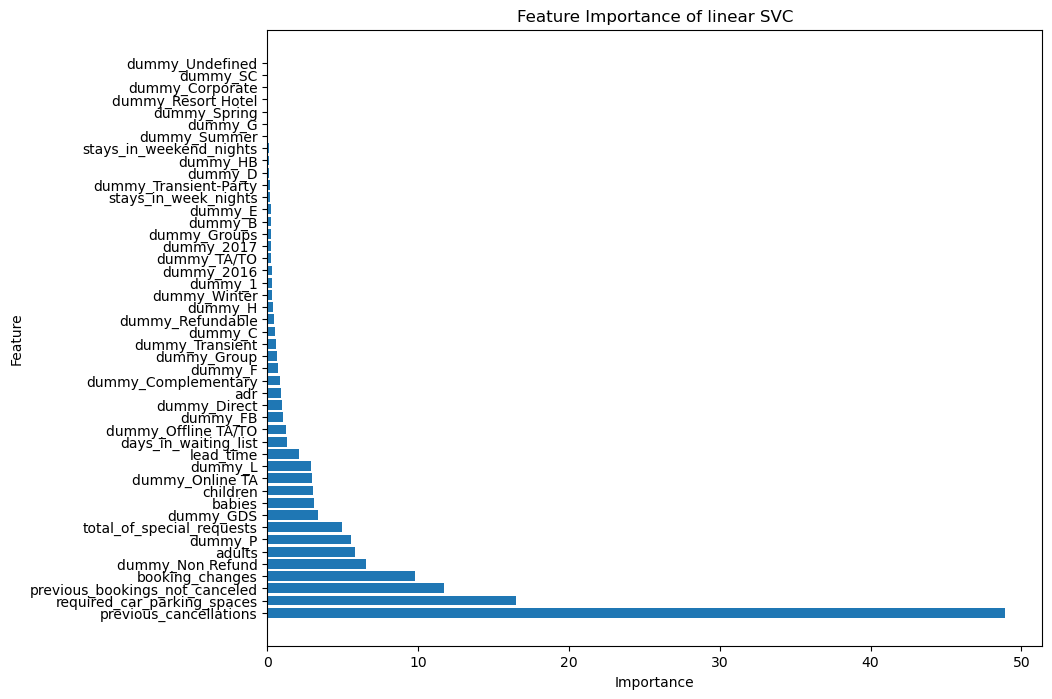

"\nresult = permutation_importance(svm_model, X_train_scaled, y_train, n_repeats=10, random_state=42)\nimportances = result.importances_mean\nimportance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})\nimportance_df = importance_df.sort_values(by='Importance', ascending=False)\nplt.figure(figsize=(10, 8))\nplt.barh(importance_df['Feature'], importance_df['Importance'])\nplt.title('Feature Importance')\nplt.xlabel('Importance')\nplt.ylabel('Feature')\nplt.show()\n"

In [35]:
# 1) visualize for svc_linear feature importance

coefficients = svc_linear.coef_
support_vectors = svc_linear.support_vectors_
scaled_coefficients = np.abs(coefficients) * np.linalg.norm(support_vectors, axis=1)[:, np.newaxis]
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': scaled_coefficients[0]})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance of linear SVC')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 2) Error in visualize for svc_poly feature importance



# 3) Error in visualize for svm_model feature importance
"""
result = permutation_importance(svm_model, X_train_scaled, y_train, n_repeats=10, random_state=42)
importances = result.importances_mean
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
"""

### 4.4.2 Set Evaluation Metrics (SVC)

In [36]:
num_folds = 10
seed = 7
#scoring = 'accuracy'
scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

### 4.4.3 Find the best SVC - by Compare SVC using K-fold cross validation

In [37]:
models = []
models.append(('SVC linear', svc_linear))
models.append(('SVC poly', svc_poly))
models.append(('SVM', svm_model))

In [38]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "Average precision score of %s: %f" % (name, cv_results.mean())
    print(msg)

Average precision score of SVC linear: 0.776012
Average precision score of SVC poly: 0.844710
Average precision score of SVM: 0.846201


### 4.4.4 SVC() is the best SVC model

- Average precision score of SVC linear: 0.776012
- Average precision score of SVC poly: 0.844710
- Average precision score of SVM: 0.846201

### 4.4.5 Model Tuning for SVC() - by using Grid Search to find best C value to aviod overfit

In [39]:
svm_model = SVC()

param_grid = {'C': [0.1, 1, 10, 100]}

grid_search = GridSearchCV(svm_model, param_grid, cv=5)

grid_search.fit(X_train_scaled, y_train)

best_C = grid_search.best_params_['C']

print("Best C value:", best_C)

# Best C value: 100

Best C value: 100


### 4.4.6 Redefine SVC(C=100) - after find out the best C value

In [74]:
svc_model = SVC(C=100)

svc_model.fit(X_train_scaled, y_train)

SVC(C=100)

### 4.4.7 Take a look for the performance of best SVC models - SVC(C=100)

In [75]:
# Calculate the training accuracy and testing accuracy
train_predictions = svc_model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_predictions)
test_predictions = svc_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.8663125
Testing Accuracy: 0.82825


In [42]:
# Classification report
classification_rep = classification_report(y_test, test_predictions)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4989
           1       0.82      0.69      0.75      3011

    accuracy                           0.83      8000
   macro avg       0.83      0.80      0.81      8000
weighted avg       0.83      0.83      0.82      8000



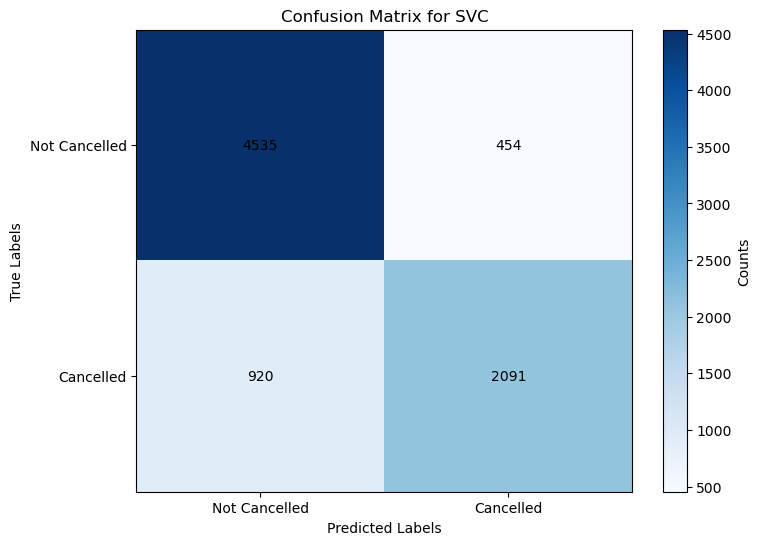

In [76]:
# confusion matrix
confusion_mat = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat, cmap='Blues', aspect='auto')
plt.colorbar(label='Counts')
class_names = ['Not Cancelled', 'Cancelled']  # Modify class names as per your problem
tick_marks = [0, 1]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, str(confusion_mat[i, j]), ha='center', va='center', color='black')  # Change the color to black

plt.title('Confusion Matrix for SVC')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.grid(False)
plt.show()

# 5. Model Evaluation <a id='4'></a>
1. We will compare the model performance based on - Learning curve
2. We will compare the model performance based on - ROC curve
3. We will compare the model performance based on - Confusion matrix

### 5.1 Learning Curve

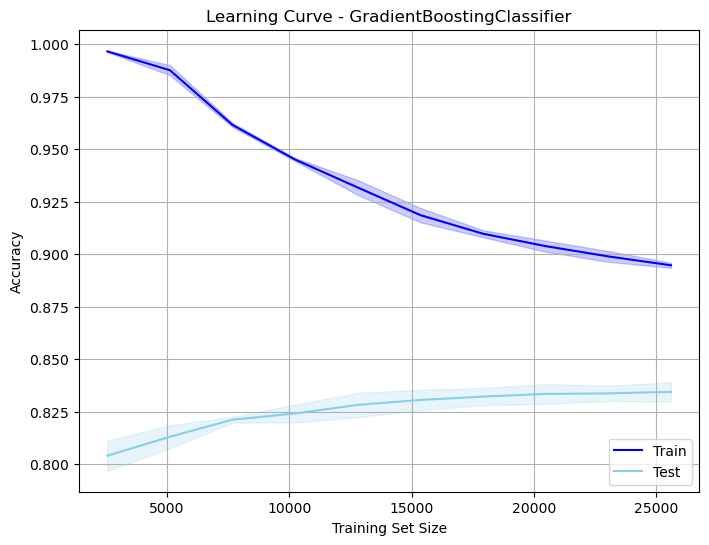

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 47 fe

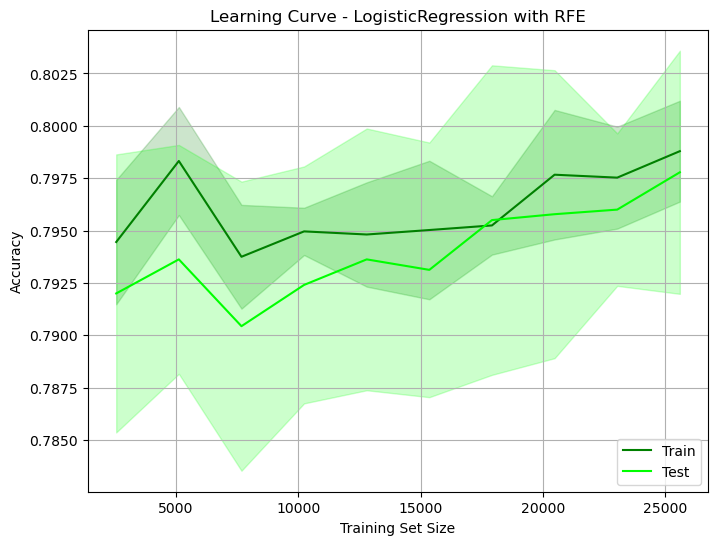

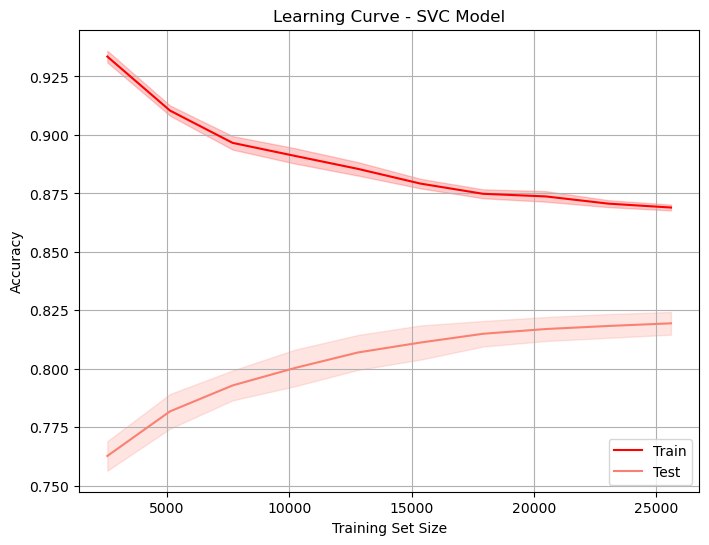

In [44]:
# Plot the learning curve for GradientBoostingClassifier

train_sizes_gb, train_scores_gb, test_scores_gb = learning_curve(gb, X_train_scaled, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean_gb = np.mean(train_scores_gb, axis=1)
train_scores_std_gb = np.std(train_scores_gb, axis=1)
test_scores_mean_gb = np.mean(test_scores_gb, axis=1)
test_scores_std_gb = np.std(test_scores_gb, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_gb, train_scores_mean_gb, label='Train', color='blue')
plt.plot(train_sizes_gb, test_scores_mean_gb, label='Test', color='skyblue')
plt.fill_between(train_sizes_gb, train_scores_mean_gb - train_scores_std_gb, train_scores_mean_gb + train_scores_std_gb, alpha=0.2, color='blue')
plt.fill_between(train_sizes_gb, test_scores_mean_gb - test_scores_std_gb, test_scores_mean_gb + test_scores_std_gb, alpha=0.2, color='skyblue')
plt.title('Learning Curve - GradientBoostingClassifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot the learning curve for LogisticRegression with RFE

train_sizes_logit, train_scores_logit, test_scores_logit = learning_curve(logit_rfe, X_train_scaled, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean_logit = np.mean(train_scores_logit, axis=1)
train_scores_std_logit = np.std(train_scores_logit, axis=1)
test_scores_mean_logit = np.mean(test_scores_logit, axis=1)
test_scores_std_logit = np.std(test_scores_logit, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_logit, train_scores_mean_logit, label='Train', color='green')
plt.plot(train_sizes_logit, test_scores_mean_logit, label='Test', color='lime')
plt.fill_between(train_sizes_logit, train_scores_mean_logit - train_scores_std_logit, train_scores_mean_logit + train_scores_std_logit, alpha=0.2, color='green')
plt.fill_between(train_sizes_logit, test_scores_mean_logit - test_scores_std_logit, test_scores_mean_logit + test_scores_std_logit, alpha=0.2, color='lime')
plt.title('Learning Curve - LogisticRegression with RFE')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Plot the learning curve for SVC model

train_sizes_svc, train_scores_svc, test_scores_svc = learning_curve(svc_model, X_train_scaled, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean_svc = np.mean(train_scores_svc, axis=1)
train_scores_std_svc = np.std(train_scores_svc, axis=1)
test_scores_mean_svc = np.mean(test_scores_svc, axis=1)
test_scores_std_svc = np.std(test_scores_svc, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_svc, train_scores_mean_svc, label='Train', color='red')
plt.plot(train_sizes_svc, test_scores_mean_svc, label='Test', color='salmon')
plt.fill_between(train_sizes_svc, train_scores_mean_svc - train_scores_std_svc, train_scores_mean_svc + train_scores_std_svc, alpha=0.2, color='red')
plt.fill_between(train_sizes_svc, test_scores_mean_svc - test_scores_std_svc, test_scores_mean_svc + test_scores_std_svc, alpha=0.2, color='salmon')
plt.title('Learning Curve - SVC Model')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 5.2 ROC plot

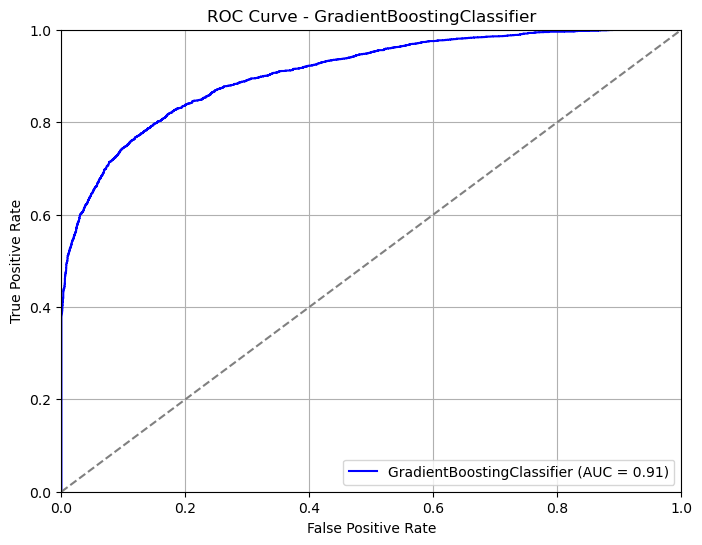

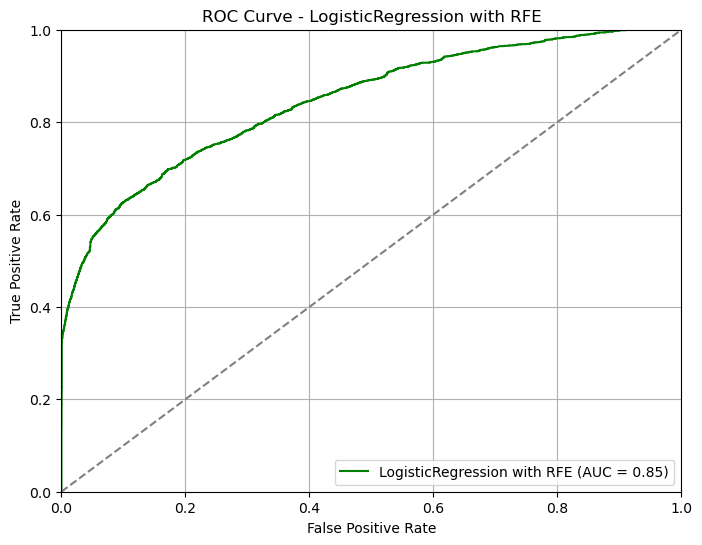

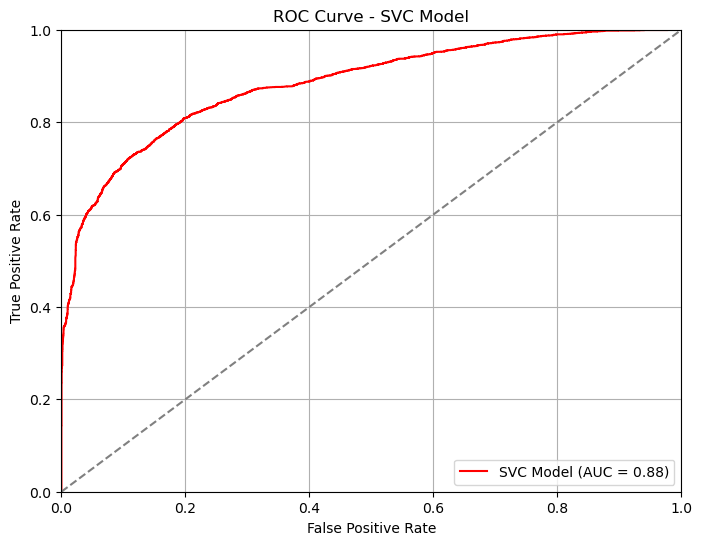

In [45]:
# 1) GradientBoostingClassifier

gb_probs = gb.predict_proba(X_test_scaled)[:, 1]
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)
gb_auc = roc_auc_score(y_test, gb_probs)
plt.figure(figsize=(8, 6))
plt.plot(gb_fpr, gb_tpr, label='GradientBoostingClassifier (AUC = {:.2f})'.format(gb_auc), color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GradientBoostingClassifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 2) LogisticRegression with RFE
logit_probs = logit_rfe.predict_proba(X_test_scaled)[:, 1]
logit_fpr, logit_tpr, _ = roc_curve(y_test, logit_probs)
logit_auc = roc_auc_score(y_test, logit_probs)
plt.figure(figsize=(8, 6))
plt.plot(logit_fpr, logit_tpr, label='LogisticRegression with RFE (AUC = {:.2f})'.format(logit_auc), color='green')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LogisticRegression with RFE')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 3) SVC model
svc_probs = svc_model.decision_function(X_test_scaled)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs)
svc_auc = roc_auc_score(y_test, svc_probs)
plt.figure(figsize=(8, 6))
plt.plot(svc_fpr, svc_tpr, label='SVC Model (AUC = {:.2f})'.format(svc_auc), color='red')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

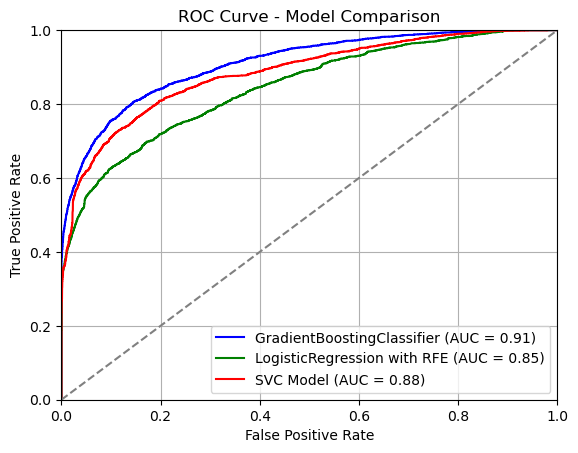

In [67]:
# Combine ROC in one

# GradientBoostingClassifier
gb_probs = gb.predict_proba(X_test_scaled)[:, 1]
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)
gb_auc = roc_auc_score(y_test, gb_probs)
plt.plot(gb_fpr, gb_tpr, label='GradientBoostingClassifier (AUC = {:.2f})'.format(gb_auc), color='blue')

# LogisticRegression with RFE
logit_probs = logit_rfe.predict_proba(X_test_scaled)[:, 1]
logit_fpr, logit_tpr, _ = roc_curve(y_test, logit_probs)
logit_auc = roc_auc_score(y_test, logit_probs)
plt.plot(logit_fpr, logit_tpr, label='LogisticRegression with RFE (AUC = {:.2f})'.format(logit_auc), color='green')

# SVC model
svc_probs = svc_model.decision_function(X_test_scaled)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs)
svc_auc = roc_auc_score(y_test, svc_probs)
plt.plot(svc_fpr, svc_tpr, label='SVC Model (AUC = {:.2f})'.format(svc_auc), color='red')

# Plot settings
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 5.3 Accuracy, Precision, Recall, F1 score

In [50]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics for gb model
gb_predictions = gb.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_precision = precision_score(y_test, gb_predictions)
gb_recall = recall_score(y_test, gb_predictions)
gb_f1 = f1_score(y_test, gb_predictions)

# Calculate metrics for logit_rfe model
logit_rfe_predictions = logit_rfe.predict(X_test_scaled)
logit_rfe_accuracy = accuracy_score(y_test, logit_rfe_predictions)
logit_rfe_precision = precision_score(y_test, logit_rfe_predictions)
logit_rfe_recall = recall_score(y_test, logit_rfe_predictions)
logit_rfe_f1 = f1_score(y_test, logit_rfe_predictions)

# Calculate metrics for svc_model
svc_model_predictions = svc_model.predict(X_test_scaled)
svc_model_accuracy = accuracy_score(y_test, svc_model_predictions)
svc_model_precision = precision_score(y_test, svc_model_predictions)
svc_model_recall = recall_score(y_test, svc_model_predictions)
svc_model_f1 = f1_score(y_test, svc_model_predictions)

# Create a dataframe
data = {
    'Model': ['GradientBoostingClassifier', 'LogisticRegression with RFE', 'SVC Model'],
    'Accuracy': [gb_accuracy, logit_rfe_accuracy, svc_model_accuracy],
    'Precision': [gb_precision, logit_rfe_precision, svc_model_precision],
    'Recall': [gb_recall, logit_rfe_recall, svc_model_recall],
    'F1 Score': [gb_f1, logit_rfe_f1, svc_model_f1]
}

metrics_df = pd.DataFrame(data)
metrics_df

Model  Accuracy  Precision    Recall  F1 Score
0   GradientBoostingClassifier  0.842750   0.851021  0.705746  0.771605
1  LogisticRegression with RFE  0.798875   0.841618  0.573564  0.682204
2                    SVC Model  0.828250   0.821611  0.694454  0.752700

## 5.4 Conclusion

Gradient boosting is the best model:
- AUC is 0.91 shows gb() have high level of model performance in distinguishing positive and negative classes
- Accuracy is 0.84 show gb() can correctly predict 84% of the instances
- Precision is 0.85 show that 85% of the positive instance are actually true positive
- Recall is 0.7 show gb() that out of all actual positive instance in the dataset, the model correctly identify 70%
- F1 score is 0.77 show the gb() can correctly identify positive instance while also minimizing false positive

# 6. Implication <a id='5'></a>
- we demonstrates an example of how machine learning models can be applied to the business world, specifically in the context of predicting customer cancellation likelihood.
- use old data for demonstration
- input of the feature, can know if a individual is cancel or not.

In [66]:
gb = GradientBoostingClassifier(n_estimators=500, max_depth=7, random_state=1)
gb.fit(X_train_scaled, y_train)

def predict_one_row(model, X):
    display(X.to_frame().T)
    result = True if model.predict(X.to_frame().T)[0] else False
    print('Possible Cancel Customer:', result)
    return result

def implication_demo():
    predict_one_row(gb, X_test_scaled_reordered.iloc[0])
    predict_one_row(gb, X_test_scaled_reordered.iloc[4])

    new_row_random_gen = pd.Series({
        key: X_test_scaled_reordered[key].iloc[random.randint(0, X_test.shape[0]-1)] for key in X_test_scaled_reordered.columns
    })

    predict_one_row(gb, new_row_random_gen)

# Reorder the columns of X_test_scaled to match the order of X_train_scaled
X_test_scaled_reordered = X_test_scaled.reindex(columns=X_train_scaled.columns)

implication_demo()

lead_time  stays_in_weekend_nights  stays_in_week_nights    adults  \
0        1.0                      0.0              0.104963  0.036364   

   children  babies  previous_cancellations  previous_bookings_not_canceled  \
0       0.0     0.0                     0.0                             0.0   

   booking_changes  days_in_waiting_list  ...  dummy_L  dummy_P  \
0              0.0                   0.0  ...      0.0      0.0   

   dummy_Non Refund  dummy_Refundable  dummy_Group  dummy_Transient  \
0               1.0               0.0          0.0              1.0   

   dummy_Transient-Party  dummy_Spring  dummy_Summer  dummy_Winter  
0                    0.0           0.0           1.0           0.0  

[1 rows x 47 columns]

Possible Cancel Customer: True


lead_time  stays_in_weekend_nights  stays_in_week_nights    adults  \
4    0.09478                 0.521855                   0.0  0.036364   

   children  babies  previous_cancellations  previous_bookings_not_canceled  \
4       0.0     0.0                     0.0                             0.0   

   booking_changes  days_in_waiting_list  ...  dummy_L  dummy_P  \
4              0.0                   0.0  ...      0.0      0.0   

   dummy_Non Refund  dummy_Refundable  dummy_Group  dummy_Transient  \
4               0.0               0.0          0.0              1.0   

   dummy_Transient-Party  dummy_Spring  dummy_Summer  dummy_Winter  
4                    0.0           1.0           0.0           0.0  

[1 rows x 47 columns]

Possible Cancel Customer: False


lead_time stays_in_weekend_nights stays_in_week_nights    adults children  \
0  0.260644                     0.0             0.369591  0.036364      0.0   

  babies previous_cancellations previous_bookings_not_canceled  \
0    0.0                    0.0                            0.0   

  booking_changes days_in_waiting_list  ... dummy_L dummy_P dummy_Non Refund  \
0             0.0                  0.0  ...     0.0     0.0              0.0   

  dummy_Refundable dummy_Group dummy_Transient dummy_Transient-Party  \
0              0.0         0.0             1.0                   0.0   

  dummy_Spring dummy_Summer dummy_Winter  
0          0.0          1.0          0.0  

[1 rows x 46 columns]

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.
